In [1]:
import pandas as pd
import os
import time
import numpy as np
import seaborn as sns
import pickle
import torch
from pathlib import Path
import argparse
import math
import matplotlib.patches as patches
from scipy import stats
from Bio import SeqIO
import matplotlib.pyplot as plt
from IPython.display import Image, display
from tqdm.notebook import tqdm
import sys
import matplotlib.image as mpimg
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, auc

sys.path.insert(0, '..')

from util.xai import gradcam, interpolate_expl_matrix, plot_matrix
from config import *
from util.evaluation import ModelResultsManager, calculate_correlations, balancing_only_for_one_task, obtain_all_model_auc, remove_outliers, map_thermodynamic_columns, obtain_df_auc, replace_outliers_with_nan_and_make_positive, obtain_sr_nosr, map_dataset_to_hp
from models.nt_classifier import build as build_model 
from util.plot_utils import obtain_plot, plot_logs, collect_results_based_on_confidence_level_how_many1, acc_for_each_class
from util.plot_utils import collect_results_based_on_confidence_level_based_on_percentile as collect_results_based_on_confidence_level
from train_binary_cl import (
    get_args_parser,
)

from dataset.data import (
    FindSplits,
    RNADatasetInference
)

<class 'transformers.tokenization_dna.DNATokenizer'>


In [2]:
external_dataset_files_dir = os.path.join(ROOT_DIR, "dataset", "external_dataset")
windows_dir = os.path.join(external_dataset_files_dir, "windows")

In [3]:
def collect_result(rna1, rna2, model):
    rna1, rna2 = rna1.to(device), rna2.to(device)
    outputs = model(rna1, rna2)
    probability = float(outputs.softmax(-1)[:, 1])
    return probability

def make_plot(heatmap_data, interacting_regions, x_range, y_range, rna1_name='RNA1', rna2_name='RNA2', model_name = 'NT', savepath = '', show_plot = False):
    # Create a DataFrame for the heatmap
    heatmap_df = pd.DataFrame(heatmap_data, columns=x_range, index=y_range)

    # Create a custom color map (cmap) that goes from 0 (blue) to 1 (red)
    cmap = sns.diverging_palette(250, 10, as_cmap=True)

    # Create the heatmap using Seaborn
    plt.figure(figsize=(12, 6))
    sns.heatmap(heatmap_df, cmap=cmap, cbar=True, vmin=0, vmax=1)

    for x1_real, width, y1_real, height in interacting_regions:
        rect = patches.Rectangle((x1_real, y1_real), width, height, linewidth=1.5, edgecolor='black', facecolor='none')
        plt.gca().add_patch(rect)

    # Set axis labels and title
    plt.xlabel(rna1_name)
    plt.ylabel(rna2_name)
    plt.title(f'{model_name} Intensity of prob for Each Window')
    
    if savepath:
        plt.savefig(savepath)

    if show_plot:
        # Show the plot
        plt.show()

In [4]:
sys.argv = ['']
parser = argparse.ArgumentParser('Training', parents=[get_args_parser()])
args = parser.parse_args()

model_name  = 'arch2_PARIStrained_PARISval0050'

# OR LIKE THIS?
checkpoint_dir = os.path.join(ROOT_DIR, 'checkpoints', f'/data01/giorgio/RNARNA-NT/checkpoints/{model_name}')
with open(os.path.join(checkpoint_dir, 'args.pkl'), 'rb') as fp:
    args = pickle.load(fp)

In [5]:
modelRM = ModelResultsManager(model_name = model_name, 
                            dimension = 200, 
                            chkpt_directory = os.path.join(ROOT_DIR, 'checkpoints'), 
                            rna_rna_files_dir = rna_rna_files_dir, 
                            test_info_directory = metadata_dir, 
                            other_tools = [], 
                            other_tools_dir = '')

In [6]:
DEVICE = 'cuda' #cpu, cuda

args_path = os.path.join(checkpoint_dir, 'args.pkl')

# Load the args namespace from the file
with open(args_path, 'rb') as f:
    args_dict = pickle.load(f)

# Convert the dictionary to an argparse.Namespace object
args = argparse.Namespace(**args_dict)
args.resume = os.path.join(checkpoint_dir, 'best_model.pth') # best_model

device = torch.device(DEVICE)
model = build_model(args)

checkpoint = torch.load(args.resume, map_location='cpu')
model.load_state_dict(checkpoint['model'])

model.to(device)
model.eval()

/data01/giorgio/ENTER/envs/dnabert/lib/python3.9/site-packages/torch/nn/init.py:388: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


BinaryClassifierNT2(
  (nt_projection_module): NTProjectionModule(
    (conv1d): Conv1d(2560, 0, kernel_size=(1,), stride=(1,))
    (bn): BatchNorm1d(2560, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (top_classifier): MLP(
    (input_layer): Sequential(
      (0): LayerNorm((5120,), eps=1e-05, elementwise_affine=True)
      (1): Linear(in_features=5120, out_features=512, bias=True)
    )
    (hidden_layers): ModuleList()
    (output_layer): Linear(in_features=512, out_features=800, bias=True)
    (activation_functions): ModuleList(
      (0): Tanh()
    )
    (dropout_layers): ModuleList(
      (0): Dropout(p=0.01, inplace=False)
    )
  )
  (small_cnn): SmallCNN(
    (conv1): Conv2d(800, 300, kernel_size=(2, 2), stride=(1, 1))
    (conv2): Conv2d(300, 300, kernel_size=(1, 1), stride=(1, 1))
    (relu): ReLU()
    (maxpool2d): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
    (tanh): Tanh()
    (global_avg_pool): AdaptiveAvgPool2d(

In [7]:
def collect_result(rna1, rna2, model):
    rna1, rna2 = rna1.to(device), rna2.to(device)
    outputs = model(rna1, rna2)
    probability = float(outputs.softmax(-1)[:, 1])
    return probability

In [8]:
STEP_SIZE = 200

### Paris 4 read

/data01/giorgio/ENTER/envs/dnabert/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (1,2,16,17,18,20) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


<AxesSubplot:xlabel='probability', ylabel='Density'>

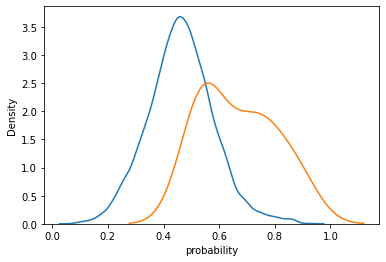

In [11]:
name_folder = f'paris_pos_4_reads'

res = modelRM.get_experiment_data(
        experiment = 'paris', 
        paris_test = True, 
        paris_finetuned_model = True, 
        specie_paris = 'all',
        paris_hq = False,
        paris_hq_threshold = 1,
        n_reads_paris = 4,
        splash_trained_model = True,
        only_test_splash_ricseq_mario = np.nan,
        n_reads_ricseq = np.nan,
        logistic_regression_models = {},
)

df_genes = pd.read_csv(os.path.join(processed_files_dir, f'df_genes.csv'))
df = pd.read_csv(os.path.join(processed_files_dir, f'paris.csv'))
df_nt = pd.read_csv(os.path.join(metadata_dir, f'df_nt.csv'))

subset = res[res.ground_truth == 1].reset_index(drop = True)

subset_to_test = df_nt[df_nt.couples.isin(subset.df_nt_id)].reset_index(drop = True)

assert set(subset.couples) == set(subset_to_test.couples_id)

id_to_test = list(subset.df_nt_id)
sns.kdeplot(res[res.couples.isin(subset.couples) & res.ground_truth == 0].probability)
sns.kdeplot(subset.probability)

### Paris repeats

In [19]:
n_samples = 30
name_folder = f'paris_random_repeat'

In [17]:
#analysis args
feature_to_search = 'Simple_repeat'


full_overlap = False
if full_overlap:
    suffix = 'full_'
else:
    suffix = ''
    
both_sr_condition = True

/data01/giorgio/ENTER/envs/dnabert/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (1,2,16,17,18,20) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


N of data:30


<AxesSubplot:xlabel='probability', ylabel='Density'>

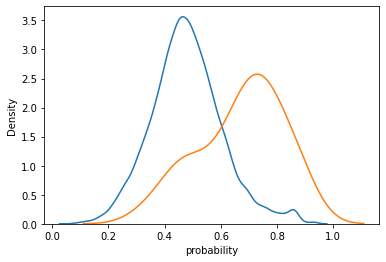

In [18]:
df_genes = pd.read_csv(os.path.join(processed_files_dir, f'df_genes.csv'))
df = pd.read_csv(os.path.join(processed_files_dir, f'paris.csv'))
df_nt = pd.read_csv(os.path.join(metadata_dir, f'df_nt.csv'))


res = modelRM.get_experiment_data(
        experiment = 'paris', 
        paris_test = True, 
        paris_finetuned_model = True, 
        specie_paris = 'all',
        paris_hq = False,
        paris_hq_threshold = 1,
        n_reads_paris = 1,
        splash_trained_model = True,
        only_test_splash_ricseq_mario = np.nan,
        n_reads_ricseq = np.nan,
        logistic_regression_models = {},
)

res['simple_repeat1'] = res[f'{suffix}feature1'].apply(lambda x: feature_to_search in x)
res['simple_repeat2'] = res[f'{suffix}feature2'].apply(lambda x: feature_to_search in x)
res['none1'] = res[f'{suffix}feature1'].apply(lambda x: 'None' in x)
res['none2'] = res[f'{suffix}feature2'].apply(lambda x: feature_to_search in x)

sr, no_sr = obtain_sr_nosr(res, both_sr_condition, ['easypos'])

subset = sr.sample(n_samples).reset_index(drop = True)

subset_to_test = df_nt[df_nt.couples.isin(subset.df_nt_id)].reset_index(drop = True)
print(f'N of data:{subset_to_test.shape[0]}')
assert set(subset.couples) == set(subset_to_test.couples_id)

id_to_test = list(subset.df_nt_id)
sns.kdeplot(res[res.couples.isin(subset.couples) & res.ground_truth == 0].probability)
sns.kdeplot(subset.probability)

### Paris score >0.85 and minimum 40 lenght

/data01/giorgio/ENTER/envs/dnabert/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (1,2,16,17,18,20) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


N of data:38


<AxesSubplot:xlabel='probability', ylabel='Density'>

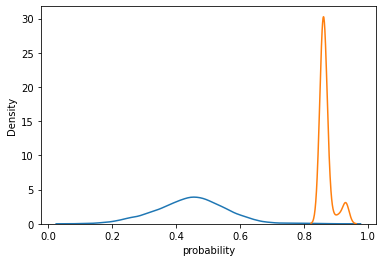

In [9]:
name_folder = f'paris_high_confidence_40lenght'

res = modelRM.get_experiment_data(
        experiment = 'paris', 
        paris_test = True, 
        paris_finetuned_model = True, 
        specie_paris = 'all',
        paris_hq = False,
        paris_hq_threshold = 40,
        n_reads_paris = 1,
        splash_trained_model = True,
        only_test_splash_ricseq_mario = np.nan,
        n_reads_ricseq = np.nan,
        logistic_regression_models = {},
)

df_genes = pd.read_csv(os.path.join(processed_files_dir, f'df_genes.csv'))
df = pd.read_csv(os.path.join(processed_files_dir, f'paris.csv'))
df_nt = pd.read_csv(os.path.join(metadata_dir, f'df_nt.csv'))

subset = res[(res.ground_truth == 1) & (res.probability>0.85)].reset_index(drop = True)

subset_to_test = df_nt[df_nt.couples.isin(subset.df_nt_id)].reset_index(drop = True)
print(f'N of data:{subset_to_test.shape[0]}')
assert set(subset.couples) == set(subset_to_test.couples_id)

id_to_test = list(subset.df_nt_id)
sns.kdeplot(res[res.couples.isin(subset.couples) & res.ground_truth == 0].probability)
sns.kdeplot(subset.probability)

### Paris minimum 40 lenght, random samples from positives (not the one we correctly classified)

/data01/giorgio/ENTER/envs/dnabert/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (1,2,16,17,18,20) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


N of data:30


<AxesSubplot:xlabel='probability', ylabel='Density'>

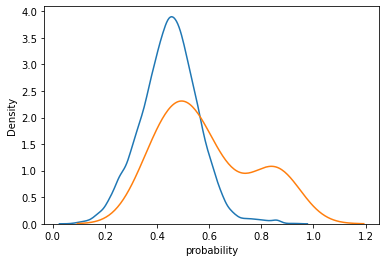

In [9]:
n_samples = 30
name_folder = f'paris_random_pos_40lenght'

res = modelRM.get_experiment_data(
        experiment = 'paris', 
        paris_test = True, 
        paris_finetuned_model = True, 
        specie_paris = 'all',
        paris_hq = False,
        paris_hq_threshold = 40,
        n_reads_paris = 1,
        splash_trained_model = True,
        only_test_splash_ricseq_mario = np.nan,
        n_reads_ricseq = np.nan,
        logistic_regression_models = {},
)

df_genes = pd.read_csv(os.path.join(processed_files_dir, f'df_genes.csv'))
df = pd.read_csv(os.path.join(processed_files_dir, f'paris.csv'))
df_nt = pd.read_csv(os.path.join(metadata_dir, f'df_nt.csv'))

subset = res[(res.ground_truth == 1)].sample(n_samples).reset_index(drop = True)

subset_to_test = df_nt[df_nt.couples.isin(subset.df_nt_id)].reset_index(drop = True)
print(f'N of data:{subset_to_test.shape[0]}')
assert set(subset.couples) == set(subset_to_test.couples_id)

id_to_test = list(subset.df_nt_id)
sns.kdeplot(res[res.couples.isin(subset.couples) & res.ground_truth == 0].probability)
sns.kdeplot(subset.probability)

### Splash score >0.85

N of data:3


<AxesSubplot:xlabel='probability', ylabel='Density'>

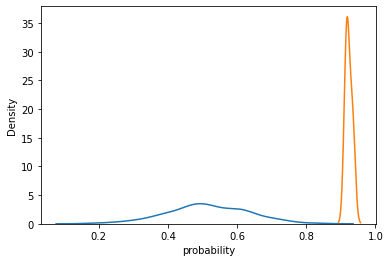

In [23]:
name_folder = f'splash_high_confidence'

res = modelRM.get_experiment_data(
        experiment = 'splash', 
        paris_test = True, 
        paris_finetuned_model = True, 
        specie_paris = 'all',
        paris_hq = False,
        paris_hq_threshold = 1,
        n_reads_paris = 1,
        splash_trained_model = True,
        only_test_splash_ricseq_mario = False,
        n_reads_ricseq = np.nan,
        logistic_regression_models = {},
)

df_genes = pd.read_csv(os.path.join(processed_files_dir, f'df_genes_splash.csv'))
df = pd.read_csv(os.path.join(processed_files_dir, f'splash.csv'))
df_nt = pd.read_csv(os.path.join(metadata_dir, f'df_nt_splash.csv'))

subset = res[(res.ground_truth == 1) & (res.probability>0.85)].reset_index(drop = True)

subset_to_test = df_nt[df_nt.couples.isin(subset.df_nt_id)].reset_index(drop = True)
print(f'N of data:{subset_to_test.shape[0]}')
assert set(subset.couples) == set(subset_to_test.couples_id)

id_to_test = list(subset.df_nt_id)
sns.kdeplot(res[res.couples.isin(subset.couples) & res.ground_truth == 0].probability)
sns.kdeplot(subset.probability)

### Ricseq score >0.85

N of data:20


<AxesSubplot:xlabel='probability', ylabel='Density'>

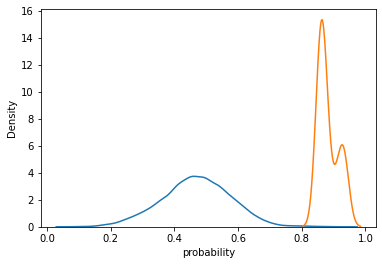

In [31]:
name_folder = f'ricseq_high_confidence'

res = modelRM.get_experiment_data(
        experiment = 'ricseq', 
        paris_test = True, 
        paris_finetuned_model = True, 
        specie_paris = 'all',
        paris_hq = False,
        paris_hq_threshold = 1,
        n_reads_paris = 1,
        splash_trained_model = True,
        only_test_splash_ricseq_mario = False,
        n_reads_ricseq = 1,
        logistic_regression_models = {},
)

df_genes = pd.read_csv(os.path.join(processed_files_dir, f'df_genes.csv'))
df = pd.read_csv(os.path.join(processed_files_dir, f'ricseq.csv'))
df_nt = pd.read_csv(os.path.join(metadata_dir, f'df_nt_ricseq.csv'))

subset = res[(res.ground_truth == 1) & (res.probability>0.85)].reset_index(drop = True)

subset_to_test = df_nt[df_nt.couples.isin(subset.df_nt_id)].reset_index(drop = True)
print(f'N of data:{subset_to_test.shape[0]}')
assert set(subset.couples) == set(subset_to_test.couples_id)

id_to_test = list(subset.df_nt_id)
sns.kdeplot(res[res.couples.isin(subset.couples) & res.ground_truth == 0].probability)
sns.kdeplot(subset.probability)

In [20]:
subset_to_test['window_x1']=subset_to_test.gene1.str.extractall('(.*)_(.*)_(.*)').reset_index(drop= True)[1].astype(int)
subset_to_test['window_y1']=subset_to_test.gene2.str.extractall('(.*)_(.*)_(.*)').reset_index(drop= True)[1].astype(int)
subset_to_test['gene1_original']=subset_to_test.gene1.str.extractall('(.*)_(.*)_(.*)').reset_index(drop= True)[0]
subset_to_test['gene2_original']=subset_to_test.gene2.str.extractall('(.*)_(.*)_(.*)').reset_index(drop= True)[0]

couples_to_test = list(set(subset_to_test.couples_id))
id_to_test = list(set(subset_to_test.couples))

output_dir = os.path.join(windows_dir, name_folder)
if os.path.isdir(output_dir) == False:
    os.mkdir(output_dir)

In [21]:
# ------ greather or less than 6000 --------

for id_s in tqdm(id_to_test, total = len(id_to_test)):

    subset_nt = subset_to_test[subset_to_test.couples == id_s]

    for _, row_nt in subset_nt.iterrows():

        gene1, gene2 = row_nt.gene1_original, row_nt.gene2_original
        len1 = row_nt.length_1
        len2 = row_nt.length_2
        couples = row_nt.couples_id
        id_sample = id_s
        emb1_name = row_nt.gene1 + '.npy'
        emb2_name = row_nt.gene2 + '.npy'
        x1_start = int(row_nt.window_x1)
        y1_start = int(row_nt.window_y1)
        policy = row_nt.policy
        cdna1 = df_genes[df_genes.gene_id == gene1]['cdna'].iloc[0] 
        cdna2 = df_genes[df_genes.gene_id == gene2]['cdna'].iloc[0] 


        all_interactions = df[df.couples == couples]
        interacting_regions = []
        
        for _, row in all_interactions.iterrows():
            x1_real, width = int(row.x1), int(row.w)
            y1_real, height = int(row.y1), int(row.h)
            if gene1 + '_' + gene2 == couples:
                interacting_regions.append([x1_real - x1_start, width, y1_real - y1_start, height])
            elif gene2 + '_' + gene1 == couples:
                interacting_regions.append([y1_real - x1_start, height, x1_real - y1_start, width])
            else:
                raise NotImplementedError


        emb1_path = os.path.join(embedding_dir, '32', emb1_name)
        emb2_path = os.path.join(embedding_dir, '32', emb2_name)

        assert os.path.isfile(emb1_path)
        assert os.path.isfile(emb2_path)

        emb1 = np.load(emb1_path)
        emb2 = np.load(emb2_path)    

        # no overlap setup
        step_size = STEP_SIZE
        fs = FindSplits(max_size = step_size + 1)
        gene1_coords = pd.Series(len1).apply(lambda x: fs.get_split_coords(length = x, step_size=step_size)).iloc[0]
        gene2_coords = pd.Series(len2).apply(lambda x: fs.get_split_coords(length = x, step_size=step_size)).iloc[0]
        
        #print(f'POLICY: {policy}')



        coord_dict = {}

        idx = 0

        for (x1, x2) in gene1_coords:
            for (y1, y2) in gene2_coords:

                cdna1_slice = cdna1[x1_start + x1: x1_start + x2]
                cdna2_slice = cdna2[y1_start + y1: y1_start + y2]

                assert len(cdna1_slice) == x2-x1
                assert len(cdna2_slice) == y2-y1

                x1_emb, x2_emb, y1_emb, y2_emb = x1//6, x2//6, y1//6, y2//6
                embedding1 = emb1[x1_emb:x2_emb, :]
                embedding2 = emb2[y1_emb:y2_emb, :]
                rna1, rna2 =  torch.as_tensor(embedding1).unsqueeze(0), torch.as_tensor(embedding2).unsqueeze(0)
                rna1, rna2 = torch.transpose(rna1, 1, 2), torch.transpose(rna2, 1, 2)
                probability = collect_result(rna1, rna2, model)
                coord_dict[idx] = {'x1': x1, 'x2':x2, 'y1':y1, 'y2':y2, 'prob':probability,
                                   'cdna1_slice':cdna1_slice, 'cdna2_slice':cdna2_slice}
                idx += 1



        result = pd.DataFrame.from_dict(coord_dict, 'index')

        assert result.shape[0] > 0
        
        dir_couple = os.path.join(output_dir, couples)
        if os.path.isdir(dir_couple) == False:
            os.mkdir(dir_couple)

        dir_row = os.path.join(dir_couple, str(id_sample))
        if os.path.isdir(dir_row) == False:
            os.mkdir(dir_row)

        result.to_csv(os.path.join(dir_row, 'nt_result.csv'), index = False)
        with open(os.path.join(dir_row, 'interacting_regions.pkl'), 'wb') as file:
            pickle.dump(interacting_regions, file)

        #CREATE INTARNA FASTA
        rna1 = open(os.path.join(output_dir, 'rna1.fasta'), "a")
        rna2 = open(os.path.join(output_dir, 'rna2.fasta'), "a")

        for _, row in result.iterrows():
            name1 = str(id_sample) + '_' + str(row.x1) + '_' + str(row.x2) + '_rna1'
            name2 = str(id_sample) + '_' + str(row.y1) + '_' + str(row.y2) + '_rna2'
            rna1.write(">" + name1 + "\n" + row.cdna1_slice + "\n")
            rna2.write(">" + name2 + "\n" + row.cdna2_slice + "\n")

        rna1.close()
        rna2.close()

  0%|          | 0/30 [00:00<?, ?it/s]

# Let's read and save the results

In [22]:
output_dir = os.path.join(windows_dir,name_folder)

In [23]:
couples_to_test = [i for i in os.listdir(output_dir) if i.startswith('EN')]
id_to_test = []

for c in couples_to_test:
    for i in os.listdir(os.path.join(output_dir, c)):
        id_to_test.append(i)

In [24]:
plot_dir = os.path.join(output_dir, 'plots')
if os.path.isdir(plot_dir) == False:
    os.mkdir(plot_dir)

In [25]:
show_plot = True

  0%|          | 0/30 [00:00<?, ?it/s]

easypos ENSG00000077157_8551_14521 ENSG00000218891_0_2922


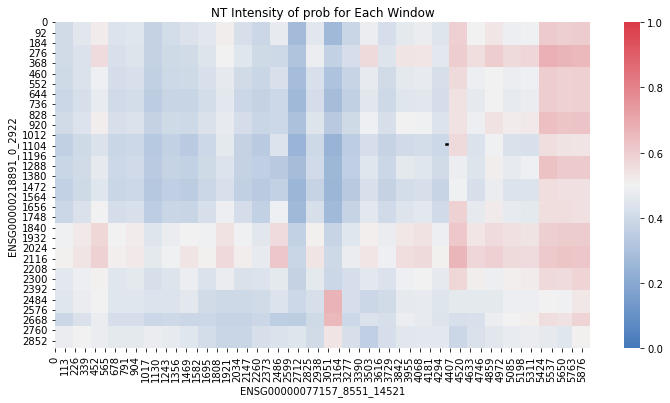

easypos ENSMUSG00000020402_0_2022 ENSMUSG00000030795_0_5536


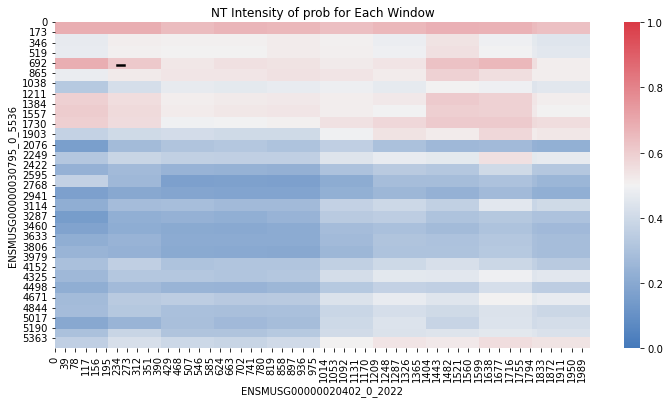

easypos ENSG00000109861_68_6038 ENSG00000259705_0_1943


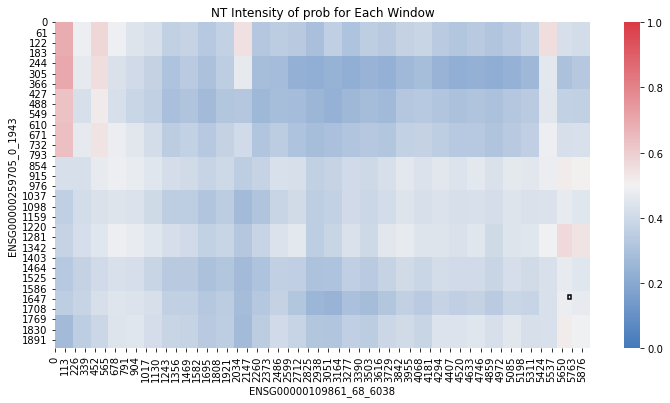

easypos ENSG00000143373_0_5378 ENSG00000196437_0_4495


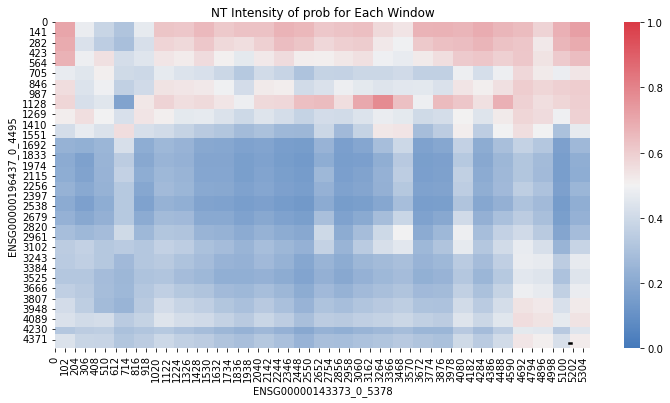

easypos ENSMUSG00000029103_0_2981 ENSMUSG00000097971_0_3329


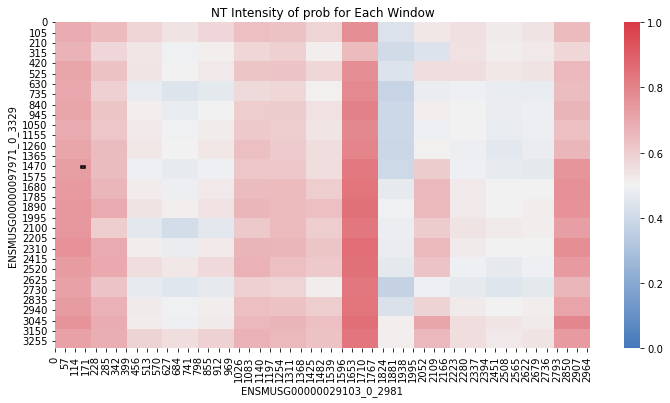

easypos ENSG00000116604_0_5912 ENSG00000165175_0_3781


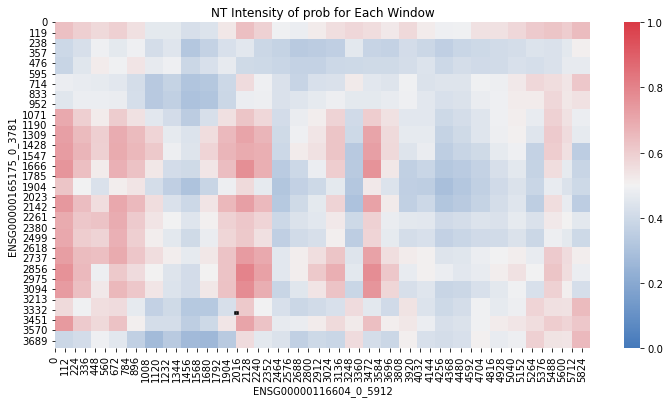

easypos ENSG00000120896_0_3459 ENSG00000148082_127_6097


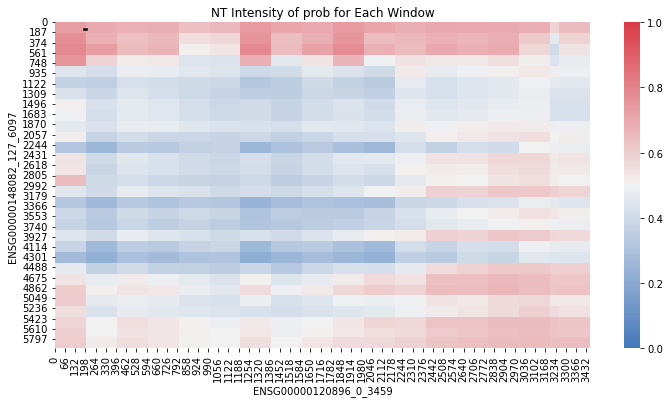

easypos ENSMUSG00000039270_70_6040 ENSMUSG00000049598_0_1801


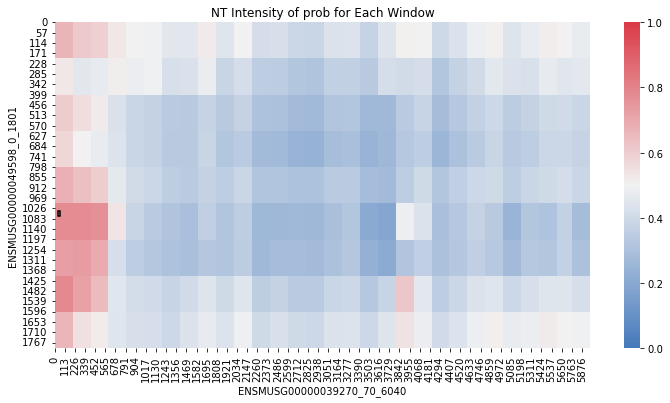

easypos ENSMUSG00000028370_146_6116 ENSMUSG00000033768_261_6231


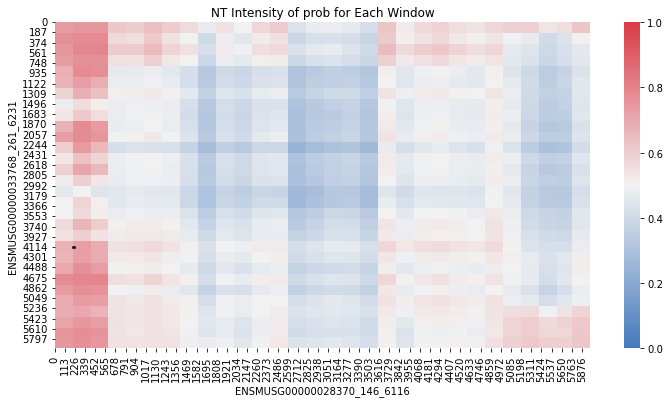

easypos ENSG00000105576_0_5122 ENSG00000196504_34_6004


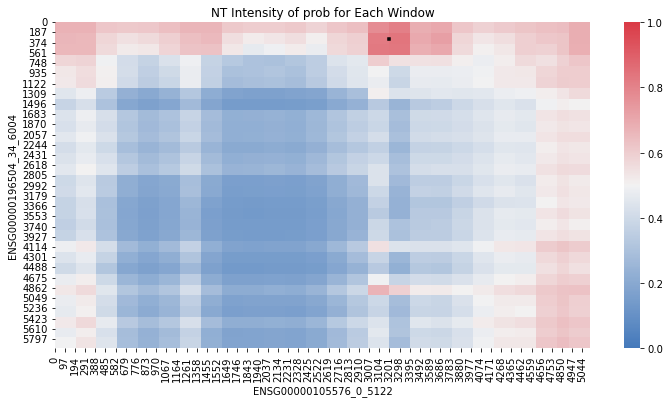

easypos ENSG00000155966_7493_13463 ENSG00000261644_0_2296


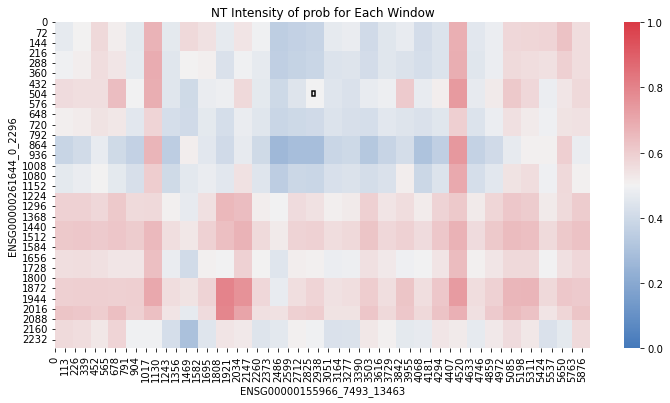

easypos ENSG00000158864_0_2064 ENSG00000175984_204_6174


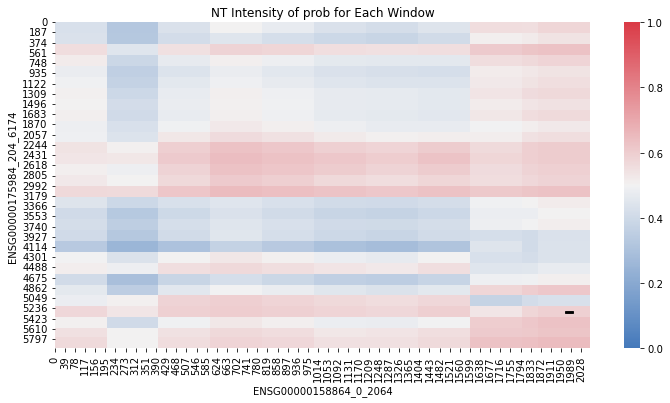

easypos ENSMUSG00000022957_65_6035 ENSMUSG00000038127_10_5980


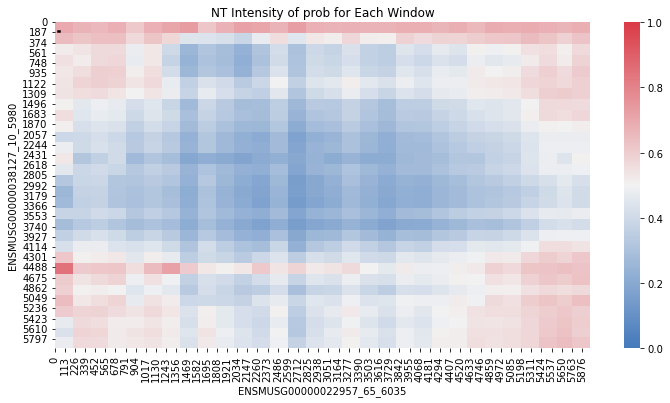

easypos ENSMUSG00000030987_0_4362 ENSMUSG00000097545_0_4103


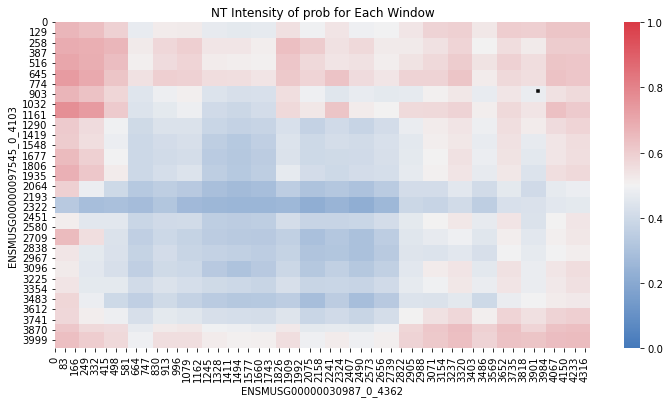

easypos ENSG00000150907_0_5779 ENSG00000196715_106_6076


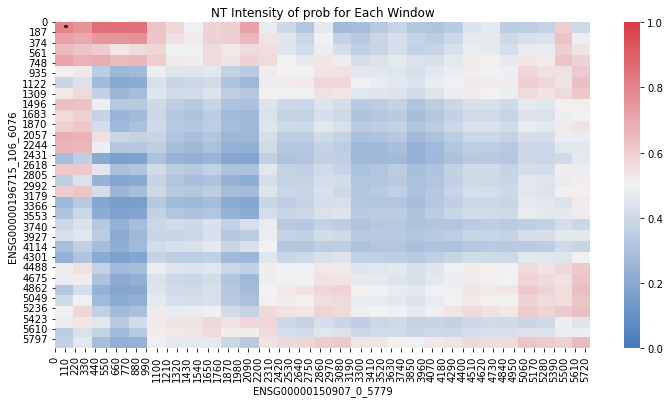

easypos ENSMUSG00000022957_68_6038 ENSMUSG00000064225_51_6021


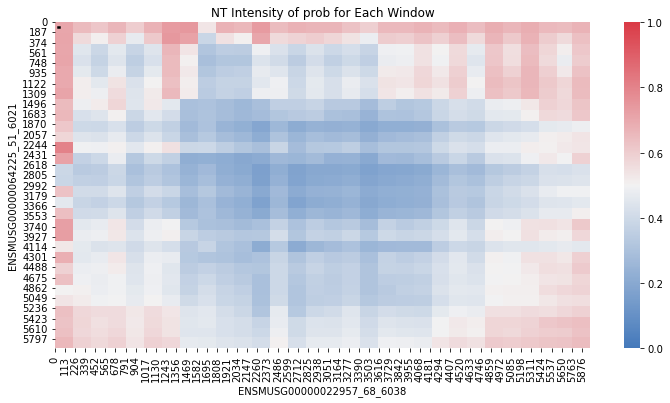

easypos ENSG00000139645_28_5998 ENSG00000147144_0_3857


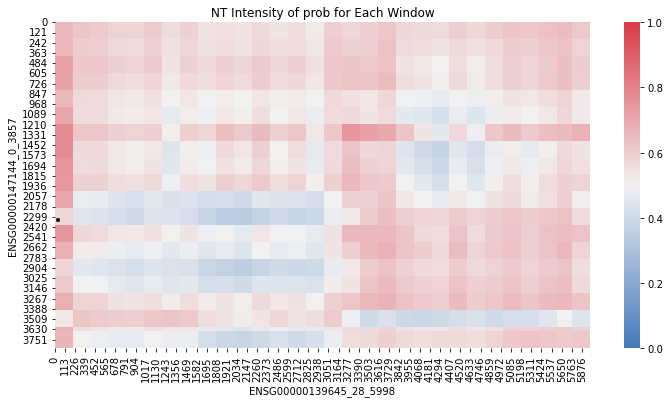

easypos ENSMUSG00000020599_0_3464 ENSMUSG00000109536_14793_20763


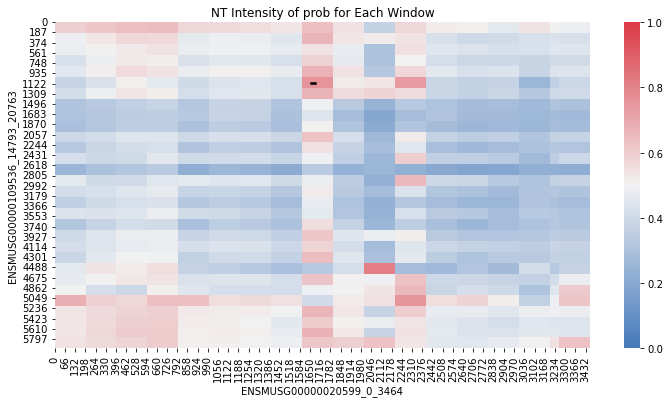

easypos ENSG00000160584_6_5976 ENSG00000283122_0_3347


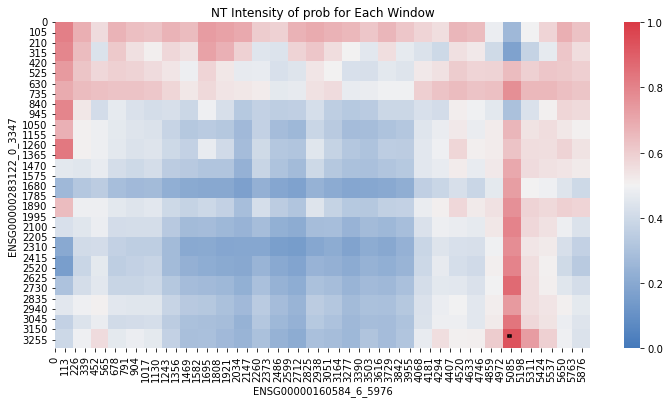

easypos ENSG00000169181_0_5128 ENSG00000253932_0_3488


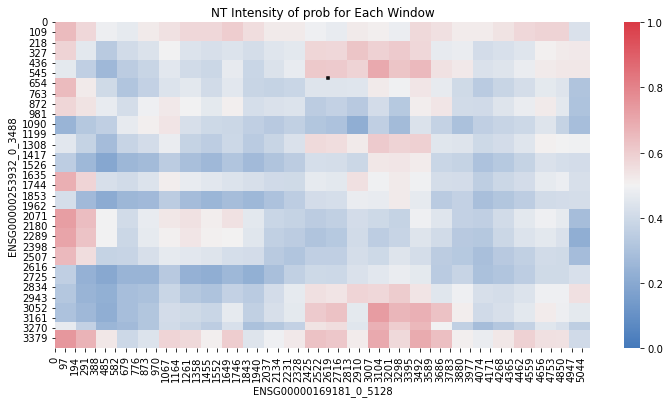

easypos ENSMUSG00000028176_257_6227 ENSMUSG00000028782_0_5170


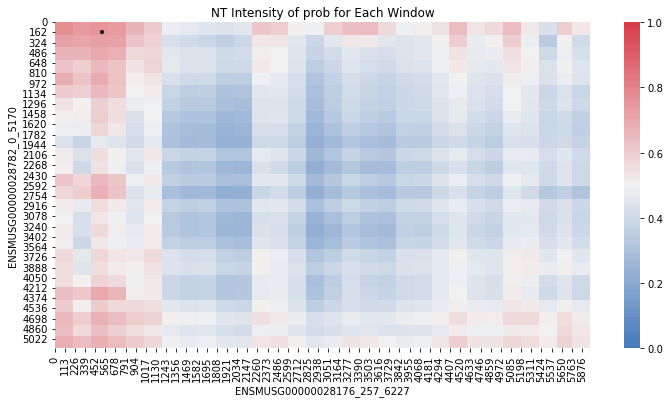

easypos ENSG00000180229_24_5994 ENSG00000184194_0_4485


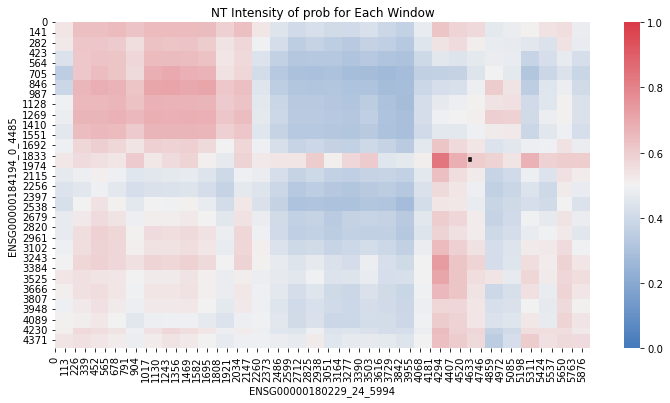

easypos ENSG00000060339_0_4658 ENSG00000127564_0_2308


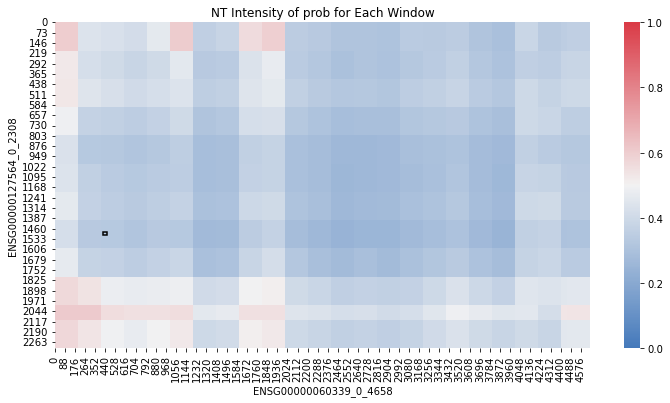

easypos ENSG00000100612_0_2322 ENSG00000116985_0_4826


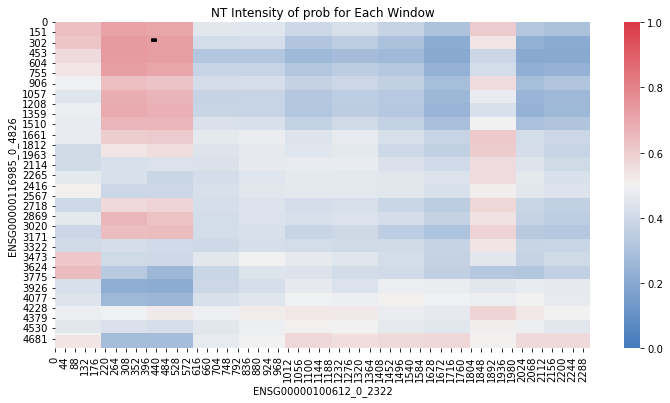

easypos ENSG00000105576_0_5122 ENSG00000113389_452_6422


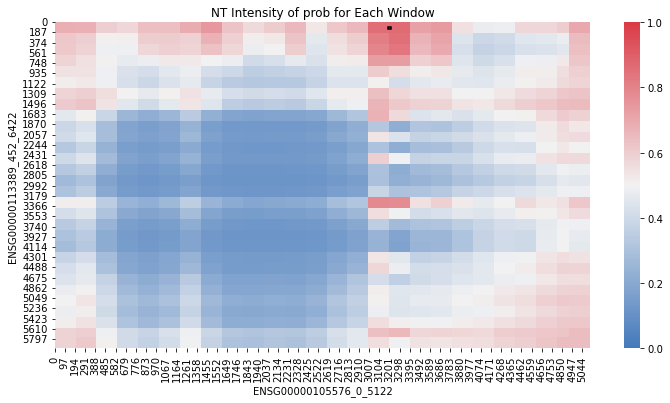

easypos ENSMUSG00000024462_0_5248 ENSMUSG00000031016_0_3419


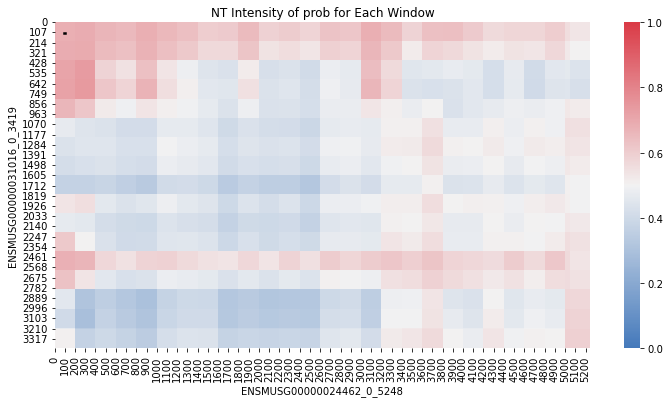

easypos ENSMUSG00000025404_0_4281 ENSMUSG00000028782_0_5170


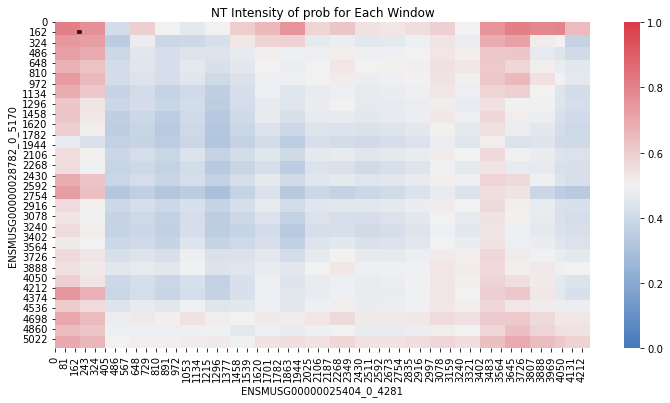

easypos ENSG00000100852_1569_7539 ENSG00000188976_0_2757


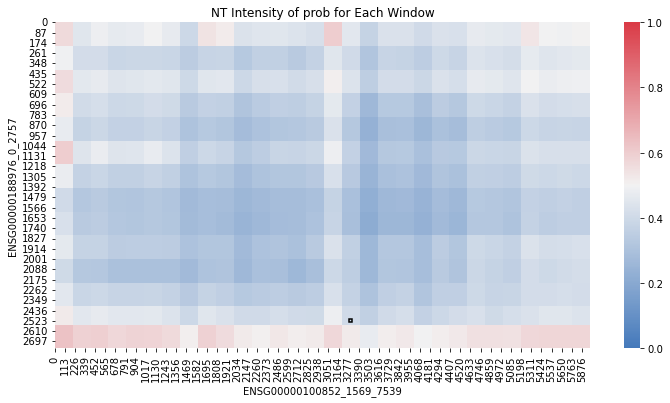

easypos ENSG00000180592_139_6109 ENSG00000245848_0_2601


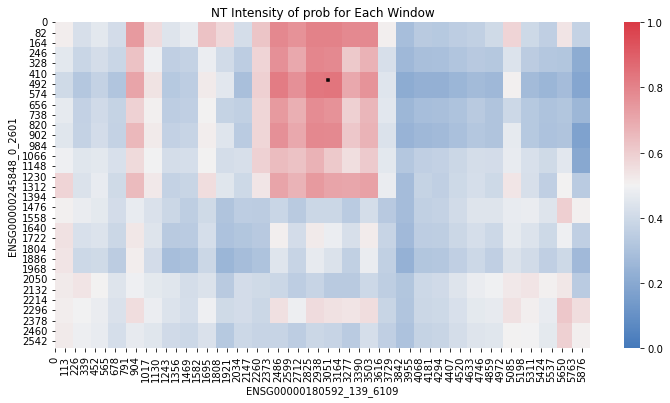

easypos ENSG00000165215_0_1274 ENSG00000169891_42_6012


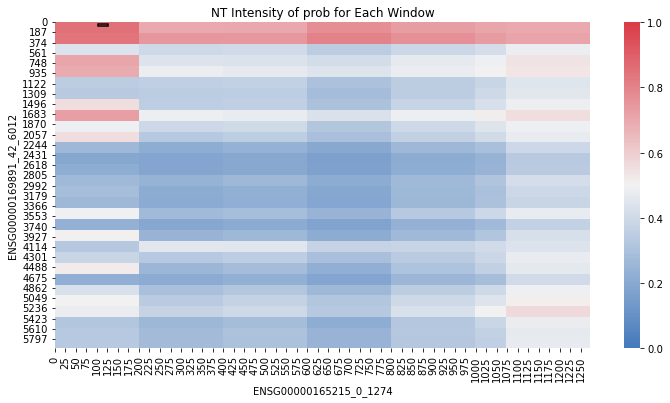

In [26]:
for id_s in tqdm(id_to_test, total = len(id_to_test)): # for couples in tqdm(couples_to_test, total = len(couples_to_test))

    subset_nt = subset_to_test[subset_to_test.couples == int(id_s)] #subset_nt = df_nt[df_nt.couples == couples]

    for _, row_nt in subset_nt.iterrows():
        
        print(row_nt.policy, row_nt.gene1, row_nt.gene2)
        
        couples = row_nt.couples_id
        policy = row_nt.policy
        id_sample = row_nt.couples
        
        dir_couple = os.path.join(output_dir, couples)
        dir_row = os.path.join(dir_couple, str(id_sample))
        result = pd.read_csv(os.path.join(dir_row, 'nt_result.csv'))
        with open(os.path.join(dir_row, 'interacting_regions.pkl'), 'rb') as file:
            interacting_regions = pickle.load(file)        
        
        # Define the range of x and y values
        x_range = range(0, int(result.max().x2))
        y_range = range(0, int(result.max().y2))

        # Create an empty 2D array to store the prob values in the grid
        heatmap_data = [[0 for _ in x_range] for _ in y_range]
        
        # Fill the heatmap_data with 'prob' values
        for _, row in result.iterrows():
            x1, x2, y1, y2, prob, cdna1_slice, cdna2_slice = row
            x1, x2, y1, y2 = int(x1), int(x2), int(y1), int(y2)
            for x in range(x1, x2):
                for y in range(y1, y2):
                    heatmap_data[y][x] = prob
                    
        name = str(id_sample) + policy + couples
        
        if os.path.exists(os.path.join(plot_dir, name + '_NT.png')) == False:
            make_plot(heatmap_data, interacting_regions, x_range, y_range, rna1_name=row_nt.gene1, rna2_name=row_nt.gene2, model_name = 'NT', savepath = os.path.join(plot_dir, name + '_NT.png'), show_plot = show_plot)